In [1]:
import os
import time

import torchvision
from matplotlib import pyplot as plt
from tqdm import tqdm

import test_config_cvppp  # for CVPPP"
import torch
from datasets import get_dataset
from models import get_model
from utils.utils_cvppp import Cluster, Visualizer  # for CVPPP

torch.backends.cudnn.benchmark = True

args = test_config_cvppp.get_args()

In [5]:
if args['display']:
    plt.ion()
else:
    plt.ioff()
    plt.switch_backend("agg")

if args['save']:
    if not os.path.exists(args['save_dir']):
        os.makedirs(args['save_dir'])

# set device
device = torch.device("cuda:0" if args['cuda'] else "cpu")

# dataloader
dataset = get_dataset(
    args['dataset']['name'], args['dataset']['kwargs'])
dataset_it = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, drop_last=False, num_workers=0, pin_memory=True if args['cuda'] else False)

# image files:  28
# label files:  28
CVPPP Dataset created [val]


## Load model

In [6]:
# load model
model = get_model(args['model']['name'], args['model']['kwargs'])
model = torch.nn.DataParallel(model).to(device)


state = torch.load(args['checkpoint_path'])
model.load_state_dict(state['model_state_dict'], strict=True)
model.eval()

Creating branched erfnet with [3, 1] classes


DataParallel(
  (module): BranchedERFNet(
    (encoder): Encoder(
      (initial_block): DownsamplerBlock(
        (conv): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layers): ModuleList(
        (0): DownsamplerBlock(
          (conv): Conv2d(16, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): non_bottleneck_1d(
          (conv3x1_1): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
          (conv1x3_1): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
          (bn1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=Tr

## Get prediction

In [7]:
for i, sample in enumerate(tqdm(dataset_it)):

    im = sample['image']
    instances = sample['instance'].squeeze(1)
    class_labels = sample['label'].squeeze(1)
    
    if i == 0:
        break

  0%|                                                                                           | 0/28 [00:00<?, ?it/s]


In [8]:
output = model(im)
print(output.shape)

torch.Size([1, 4, 512, 512])


## Instance segmentation result

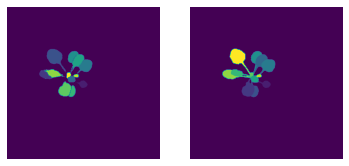

In [9]:
cluster = Cluster()
visualizer = Visualizer(('image', 'pred', 'sigma', 'seed'))

instance_map, predictions = cluster.cluster(output[0], threshold=0.9)
visualizer.display([instance_map.cpu(), instances.cpu()], 'pred')

## Post-processing in detail

In [10]:
prediction = output[0]
n_sigma = 1
threshold = 0.9

height, width = prediction.size(1), prediction.size(2)

# Define Coordinate map
xm = torch.linspace(0, 1, 512).view(1, 1, -1).expand(1, 512, 512)
ym = torch.linspace(0, 1, 512).view(1, -1, 1).expand(1, 512, 512)
xym = torch.cat((xm, ym), 0)
xym = xym.cuda()
xym_s = xym[:, 0:height, 0:width]

# Calculate spatial embedding
spatial_emb = torch.tanh(prediction[0:2]) + xym_s  # 2 x h x w
sigma = prediction[2:2 + n_sigma]  # n_sigma x h x w

# sigmoid is applied to seed_map
# as the regression loss is used for training, b.g pixels become zero
# it is similar to semantic mask
seed_map = torch.sigmoid(prediction[2 + n_sigma:2 + n_sigma + 1])  # 1 x h x w

instance_map = torch.zeros(height, width).byte()
instances = []

count = 1

# RoI pixels - set of pixels belonging to instances
mask = seed_map > 0.5  # (1, h, w)

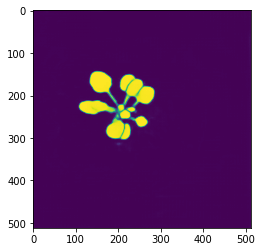

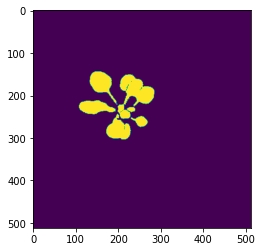

In [11]:
plt.imshow(seed_map.cpu().detach().numpy()[0])  # seed_map
plt.show()
plt.imshow((mask*1).cpu().detach().numpy()[0])  # seed_map > 0.5
plt.show()

# non-zero pixels(yellow area) are roi pixels which belong to semantic-mask area
# in this case total 43753 pixels are belong to semantic-mask area

### Get semantic-seg prediction

In [13]:
import numpy as np

sem_seg_pred = (mask*1).cpu().detach().numpy()[0]
sem_seg_pred = sem_seg_pred.astype(np.uint8)

print(np.unique(sem_seg_pred))
print(sem_seg_pred.dtype)
print(sem_seg_pred.shape)

[0 1]
uint8
(512, 512)


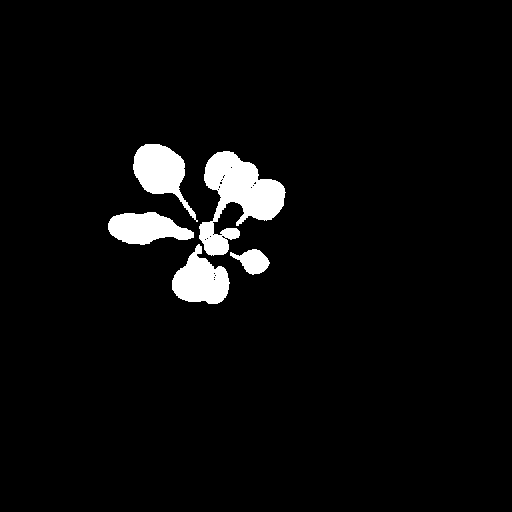

In [14]:
from PIL import Image

fg_seg_pred = sem_seg_pred
fg_seg_pred = fg_seg_pred * 255
fg_seg_pred_pil = Image.fromarray(fg_seg_pred)
fg_seg_pred_pil

In [15]:
name = sample['im_name'][0].split('\\')[-1][:-4]
fg_seg_pred_pil.save(os.path.join(name + '-fg_mask.png'))

### Clustering

In [16]:
spatial_emb_masked = spatial_emb[mask.expand_as(spatial_emb)].view(2, -1)
sigma_masked = sigma[mask.expand_as(sigma)].view(n_sigma, -1)
seed_map_masked = seed_map[mask].view(1, -1)

unclustered = torch.ones(mask.sum()).byte().cuda()
instance_map_masked = torch.zeros(mask.sum()).byte().cuda()

print('# of RoI pixels :', mask.sum())
print('spatial embedding of Roi :', spatial_emb_masked.shape)
print('sigma of Roi :', sigma_masked.shape)
print('seed map of Roi :', seed_map_masked.shape)
print('unclustered :', unclustered.shape)  # Roi pixels have to be clustered to instances

# of RoI pixels : tensor(11245, device='cuda:0')
spatial embedding of Roi : torch.Size([2, 11245])
sigma of Roi : torch.Size([1, 11245])
seed map of Roi : torch.Size([1, 11245])
unclustered : torch.Size([11245])


In [17]:
# at inference time, we select a pixel embedding with a high seed score
# embedding with the highest seed score is close to instance's center
seed = (seed_map_masked * unclustered.float()).argmax().item()
seed_score = (seed_map_masked * unclustered.float()).max().item()

# define instance center (embedding with the highest seed score)
center = spatial_emb_masked[:, seed:seed + 1]
unclustered[seed] = 0
# accompanying sigma (instance specific margin)
s = torch.exp(sigma_masked[:, seed:seed + 1] * 10)
dist = torch.exp(-1 * torch.sum(torch.pow(spatial_emb_masked -
                                            center, 2) * s, 0, keepdim=True))

# e.q (11)
proposal = (dist > 0.5).squeeze()

print('dist (score map) :', dist.shape)
print('proposal (score map > 0.5) :', proposal.shape )

dist (score map) : torch.Size([1, 11245])
proposal (score map > 0.5) : torch.Size([11245])


In [18]:
instance_map_masked[proposal.squeeze()] = count
instance_mask = torch.zeros(height, width).byte()
instance_mask[mask.squeeze().cpu()] = proposal.cpu().byte()
instances.append(
        {'mask': instance_mask.squeeze() * 255, 'score': seed_score})
count += 1

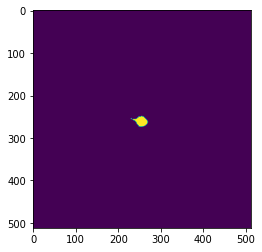

In [19]:
instance_map[mask.squeeze().cpu()] = instance_map_masked.cpu()
plt.imshow(instance_map) 
plt.show()

[{'mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8), 'score': 0.9991397857666016}]


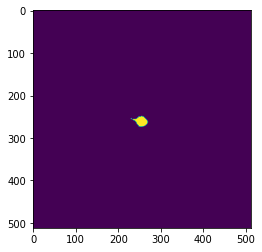

In [20]:
print(instances)  # clustered instances are added to this list
plt.imshow(instances[0]['mask'])
plt.show()

In [21]:
# one instance is clustered
# Above processes are repeated until all instances to be clustered

## Post-process all instances

In [22]:
prediction = output[0]
n_sigma = 1
threshold = 0.9

height, width = prediction.size(1), prediction.size(2)

xm = torch.linspace(0, 1, 512).view(1, 1, -1).expand(1, 512, 512)
ym = torch.linspace(0, 1, 512).view(1, -1, 1).expand(1, 512, 512)
xym = torch.cat((xm, ym), 0)

xym = xym.cuda()

xym_s = xym[:, 0:height, 0:width]

spatial_emb = torch.tanh(prediction[0:2]) + xym_s  # 2 x h x w
sigma = prediction[2:2 + n_sigma]  # n_sigma x h xw

# sigmoid is applied to seed_map
# as the regression loss is used for training, b.g pixels become zero
# it is similar to semantic mask
seed_map = torch.sigmoid(prediction[2 + n_sigma:2 + n_sigma + 1])  # 1 x h x w

instance_map = torch.zeros(height, width).byte()
instances = []

count = 1

# RoI pixels - set of pixels belonging to instances
mask = seed_map > 0.5  # (1, h, w)

if mask.sum() > 128:

    # only consider the pixels which belong to mask (RoI pixels)
    spatial_emb_masked = spatial_emb[mask.expand_as(spatial_emb)].view(2, -1)
    sigma_masked = sigma[mask.expand_as(sigma)].view(n_sigma, -1)
    seed_map_masked = seed_map[mask].view(1, -1)

    unclustered = torch.ones(mask.sum()).byte().cuda()
    instance_map_masked = torch.zeros(mask.sum()).byte().cuda()

In [23]:
while (unclustered.sum() > 128):
    # at inference time, we select a pixel embedding with a high seed score
    # embedding with the highest seed score is close to instance's center
    seed = (seed_map_masked * unclustered.float()).argmax().item()
    seed_score = (seed_map_masked * unclustered.float()).max().item()
    if seed_score < threshold:
        break

    # define instance center (embedding with the highest seed score)
    center = spatial_emb_masked[:, seed:seed + 1]
    unclustered[seed] = 0
    # accompanying sigma (instance specific margin)
    s = torch.exp(sigma_masked[:, seed:seed + 1] * 10)
    dist = torch.exp(-1 * torch.sum(torch.pow(spatial_emb_masked -
                                                          center, 2) * s, 0, keepdim=True))

    # e.q (11)
    proposal = (dist > 0.5).squeeze()

    # mask out all clustered pixels in the seed map, until all seeds are masked
    if proposal.sum() > 128:
        if unclustered[proposal].sum().float() / proposal.sum().float() > 0.5:
            instance_map_masked[proposal.squeeze()] = count
            instance_mask = torch.zeros(height, width).byte()
            instance_mask[mask.squeeze().cpu()] = proposal.cpu().byte()
            instances.append(
                {'mask': instance_mask.squeeze() * 255, 'score': seed_score})
            count += 1

    unclustered[proposal] = 0

instance_map[mask.squeeze().cpu()] = instance_map_masked.cpu()

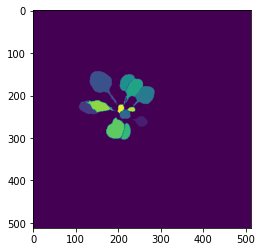

In [24]:
plt.imshow(instance_map.cpu().detach().numpy())  # all instances are clustered
plt.show()

In [25]:
print(instances)  # all of clustered instances were added

[{'mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8), 'score': 0.9991397857666016}, {'mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8), 'score': 0.9989147186279297}, {'mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8), 'score': 0.9988333582878113}, {'mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0

## Visualize all clustered instances

In [26]:
print(len(instances))  # # of clustered instances

12


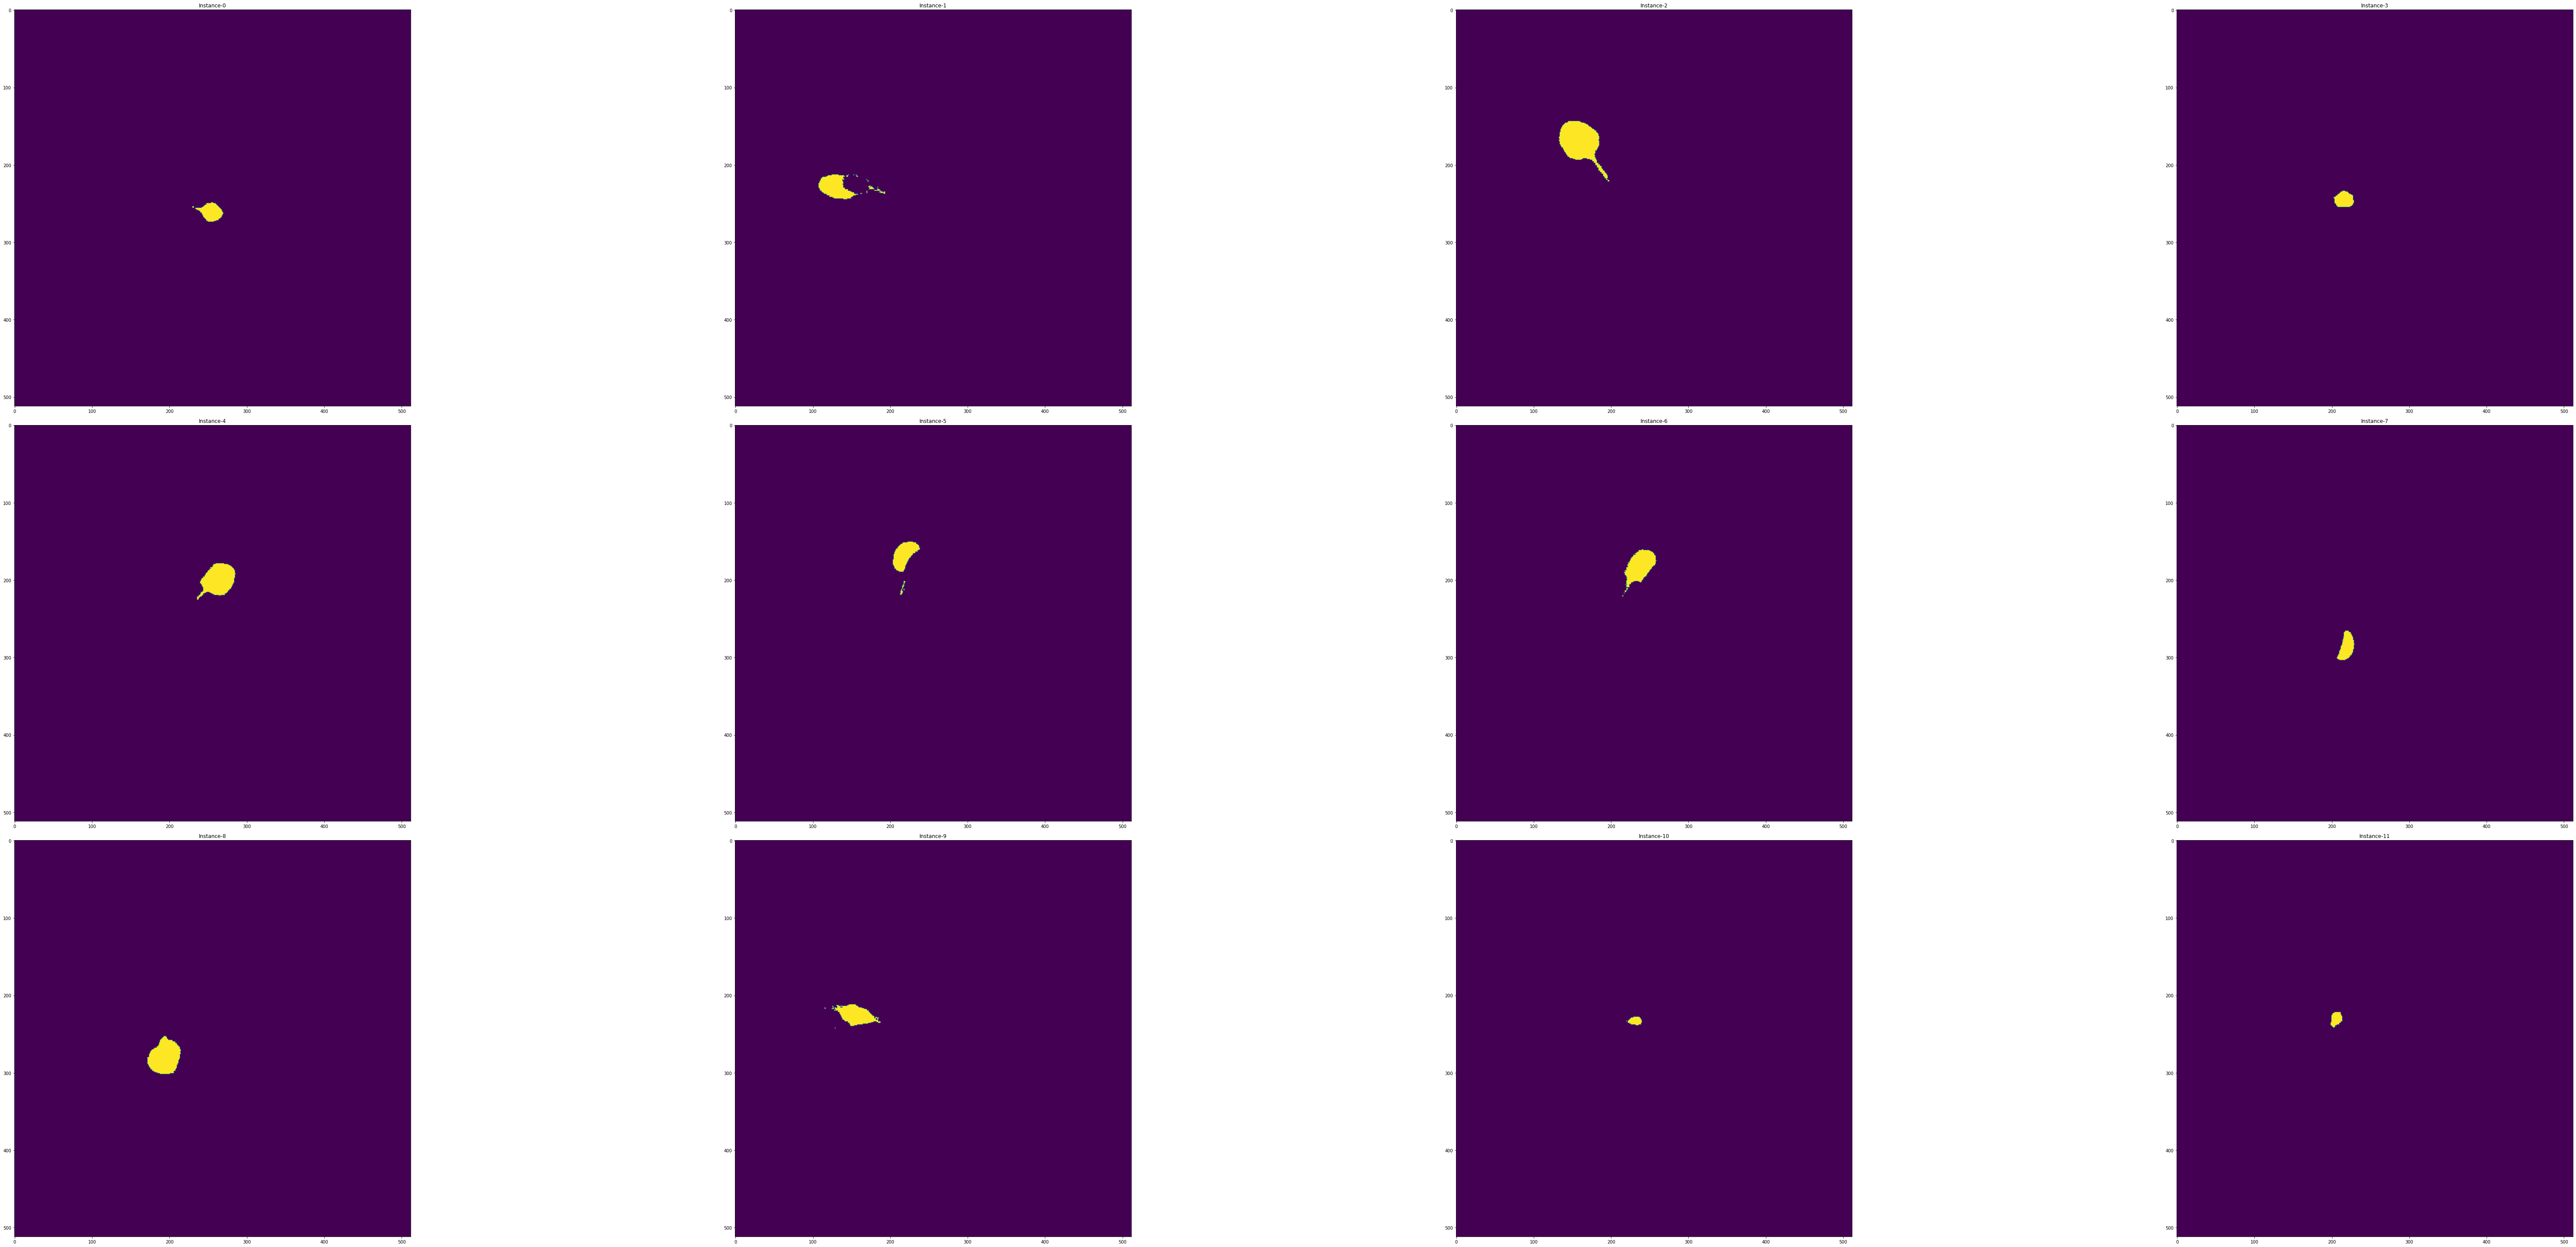

In [28]:
rows = 3
cols = 4
axes = []
fig = plt.figure(figsize=(100, 40))

for a in range(rows * cols):
    b = instances[a]['mask'].cpu().detach()
    axes.append(fig.add_subplot(rows, cols, a+1) )
    subplot_title = ("Instance-" + str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
    
fig.tight_layout()    
plt.show()

## Colorization

In [29]:
_n_clusters = len(np.unique(instance_map.flatten())) - 1  # discard bg
print(_n_clusters)

12


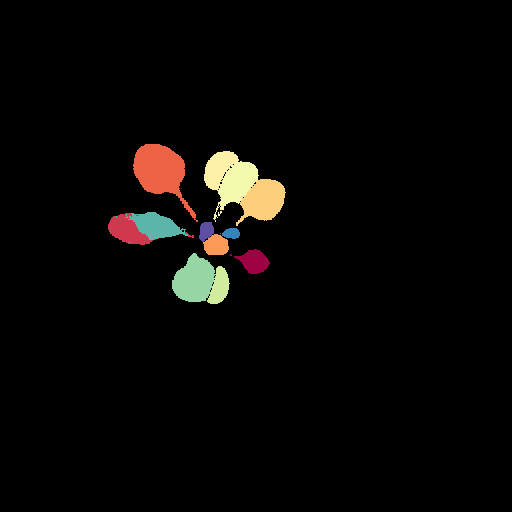

In [30]:
from PIL import Image

_n_clusters = len(np.unique(instance_map.flatten())) - 1  # discard bg
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, _n_clusters)]
ins_seg_pred_color = np.zeros(
        (instance_map.shape[0], instance_map.shape[1], 3), dtype=np.uint8)
for i in range(_n_clusters):
    ins_seg_pred_color[instance_map == (
        i + 1)] = (np.array(colors[i][:3]) * 255).astype('int')
    
ins_seg_pred_color_pil = Image.fromarray(ins_seg_pred_color)
ins_seg_pred_color_pil

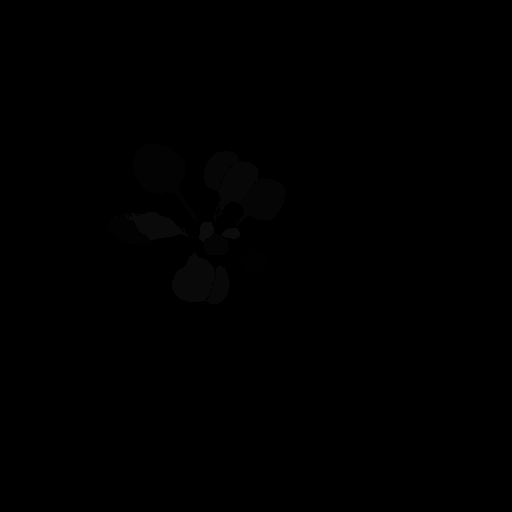

In [32]:
Image.fromarray(instance_map.numpy())

In [33]:
a = Image.fromarray(instance_map.numpy())

name = sample['im_name'][0].split('\\')[-1][:-4]
a.save(os.path.join(name + '-ins_mask.png'))